In [1]:
import rasterio
from scipy.ndimage import uniform_filter
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

In [2]:
scheme_1 =True
scheme_2 =True
scheme_3 =True
scheme_4 =True
scheme_5 =True
scheme_6 =True
scheme_7 =True

file_paths=[]


In [3]:

if scheme_1:
    model_path="output/model/RandomForest_palisades_sar_asc.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_asc.tif",
        "output_file_path": "output/prediction/1_palisadesRF_eaton_sar_asc.tif",
        "output_image_path": "output/prediction_img/1_palisadesRF_eaton_sar_asc.png",
        "title":"Scheme 1"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_asc.tif",
        "output_file_path": "output/prediction/1_palisadesRF_sar_asc.tif",
        "output_image_path": "output/prediction_img/1_palisadesRF_sar_asc.png",
        "title":"Scheme 1"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)

     

if scheme_2:
    #1 Asc glcm
    model_path="output/model/RandomForest_palisades_sar_asc_glcm.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_asc_glcm.tif",
        "output_file_path": "output/prediction/2_palisadesRF_eaton_sar_asc_glcm.tif",
        "output_image_path": "output/prediction_img/2_palisadesRF_eaton_sar_asc_glcm.png",
        "title":"Scheme 2"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_asc_glcm.tif",
        "output_file_path": "output/prediction/2_palisadesRF_sar_asc_glcm.tif",
        "output_image_path": "output/prediction_img/2_palisadesRF_sar_asc_glcm.png",
        "title":"Scheme 2"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)

    
    
if scheme_3:
    #1 Asc avg
    model_path="output/model/RandomForest_palisades_sar_avgasc.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_avgasc.tif",
        "output_file_path": "output/prediction/3_palisadesRF_eaton_sar_avgasc.tif",
        "output_image_path": "output/prediction_img/3_palisadesRF_eaton_sar_avgasc.png",
        "title":"Scheme 3"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_avgasc.tif",
        "output_file_path": "output/prediction/3_palisadesRF_sar_avgasc.tif",
        "output_image_path": "output/prediction_img/3_palisadesRF_sar_avgasc.png",
        "title":"Scheme 3"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)


    
if scheme_4:
    #1 Asc avg + glcm
    model_path="output/model/RandomForest_palisades_sar_avgasc_glcm.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_avgasc_glcm.tif",
        "output_file_path": "output/prediction/4_palisadesRF_eaton_sar_avgasc_glcm.tif",
        "output_image_path": "output/prediction_img/4_palisadesRF_eaton_sar_avgasc_glcm.png",
        "title":"Scheme 4"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_avgasc_glcm.tif",
        "output_file_path": "output/prediction/4_palisadesRF_sar_avgasc_glcm.tif",
        "output_image_path": "output/prediction_img/4_palisadesRF_sar_avgasc_glcm.png",
        "title":"Scheme 4"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)

if scheme_5:
    #avg asc + desc

    model_path="output/model/RandomForest_palisades_sar_avgasc_desc.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_avgasc_desc.tif",
        "output_file_path": "output/prediction/5_palisadesRF_eaton_sar_avgasc_desc.tif",
        "output_image_path": "output/prediction_img/5_palisadesRF_eaton_sar_avgasc_desc.png",
        "title":"Scheme 5"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_avgasc_desc.tif",
        "output_file_path": "output/prediction/5_palisadesRF_sar_avgasc_desc.tif",
        "output_image_path": "output/prediction_img/5_palisadesRF_sar_avgasc_desc.png",
        "title":"Scheme 5"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)

  
if scheme_6:
    #avg asc + desc + glcm
    model_path="output/model/RandomForest_palisades_sar_avgasc_desc_glcm.pkl"
    eaton={
        "model_path":model_path ,
        "feature_image_path": "output/feature_image/eaton_sar_avgasc_desc_glcm.tif",
        "output_file_path": "output/prediction/6_palisadesRF_eaton_sar_avgasc_desc_glcm.tif",
        "output_image_path": "output/prediction_img/6_palisadesRF_eaton_sar_avgasc_desc_glcm.png",
        "title":"Scheme 6"

    }
    palisades={
        "model_path": model_path,
        "feature_image_path": "output/feature_image/palisades_sar_avgasc_desc_glcm.tif",
        "output_file_path": "output/prediction/6_palisadesRF_sar_avgasc_desc_glcm.tif",
        "output_image_path": "output/prediction_img/6_palisadesRF_sar_avgasc_desc_glcm.png",
        "title":"Scheme 6"
    }

    file_paths.append(eaton)
    file_paths.append(palisades)

    

In [4]:
# dataset = rasterio.open("output/feature_image/palisades_sar_indices.tif")
# print(dataset.count)

# # Iterate through all bands
# for band in range(1, dataset.count + 1):
#     band_data = dataset.read(band)  # Read the band
#     min_val = np.min(band_data)
#     max_val = np.max(band_data)
    
#     print(f"Band {band}: Min = {min_val}, Max = {max_val}")

# # Close the dataset
# dataset.close()

In [5]:
def predict(model, image_path, output_file_path,output_image_path,title ):
    dataset = rasterio.open(image_path)
    print(dataset.count)

    # Read the image bands into an array (assuming it's a multi-band raster)
    sar_bands = np.stack([dataset.read(i+1) for i in range(dataset.count)], axis=-1)

    # Reshape the SAR data to a 2D array (num_pixels, num_bands)
    height, width, num_bands = sar_bands.shape
    pixels = sar_bands.reshape(-1, num_bands)  # Each row is a pixel

    # Preprocess (scale) the pixel values if needed (based on training data preprocessing)
    # scaler = StandardScaler()
    # pixels_scaled = scaler.fit_transform(pixels)  # Apply scaling to the pixels

    # Predict for each pixel
    predictions = model.predict(pixels)
    print(np.unique(predictions))

    # Assuming predictions are a 2D array (for an image or spatial data)
    predictions = uniform_filter(predictions, size=7)  # size is the window size

    # predictions = model.predict(scaler.transform(pixels))


    # Reshape predictions to match the image dimensions
    predicted_image = predictions.reshape(height, width)

    # Save the predicted classes to a new file
    # output_path = f"output/prediction/{prefix}_{model_name}_{extended_file_name}.tif"
    meta = dataset.meta
    meta.update(dtype=rasterio.uint8, count=1)  # Assuming class labels are integers, uint8 works for this

    with rasterio.open(output_file_path, 'w', **meta) as dest:
        dest.write(predicted_image.astype(rasterio.uint8), 1)  # Write to the first band

    print(f"Predictions saved to {output_file_path}")

    pred_dataset = rasterio.open(output_file_path)

    # Read the first band of the image (you can adjust for multi-band images)
    pred_band_1 = pred_dataset.read(1)

    # Plot the image
    plt.figure(figsize=(10, 10))
    cmap = mcolors.ListedColormap(['#1dc47c', '#c41d28'])

    # Plot the image with the custom colormap
    plt.imshow(pred_band_1, cmap=cmap, interpolation='nearest')
    # plt.imshow(pred_band_1, cmap='gray',interpolation='nearest')  # You can adjust the colormap if needed
    # cbar = plt.colorbar(ticks=[0, 1])
    # cbar.ax.set_yticklabels(['No', 'Yes']) 
    # plt.colorbar()
    plt.title(title)
    # Create custom legend
    legend_patches = [
        mpatches.Patch(color='#c41d28', label='Burnt'),
        mpatches.Patch(color='#1dc47c', label='Non-Burnt')
    ]

    plt.legend(handles=legend_patches, loc='lower right', frameon=True)
    plt.savefig(output_image_path,bbox_inches='tight', dpi=300)

    plt.show()





In [6]:
# ml_models=os.listdir(output_model_dir)
# for model_name in ml_models:
#     output_model_path = os.path.join(output_model_dir, model_name)
#     # Load the saved model
#     loaded_model = joblib.load(output_model_path)

#     # Use the loaded model to make predictions
#     # predictions = loaded_model.predict(X_test)
#     predict(loaded_model, sar_image_path,model_name.replace(".pkl",""))

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/1_palisadesRF_eaton_sar_asc.tif


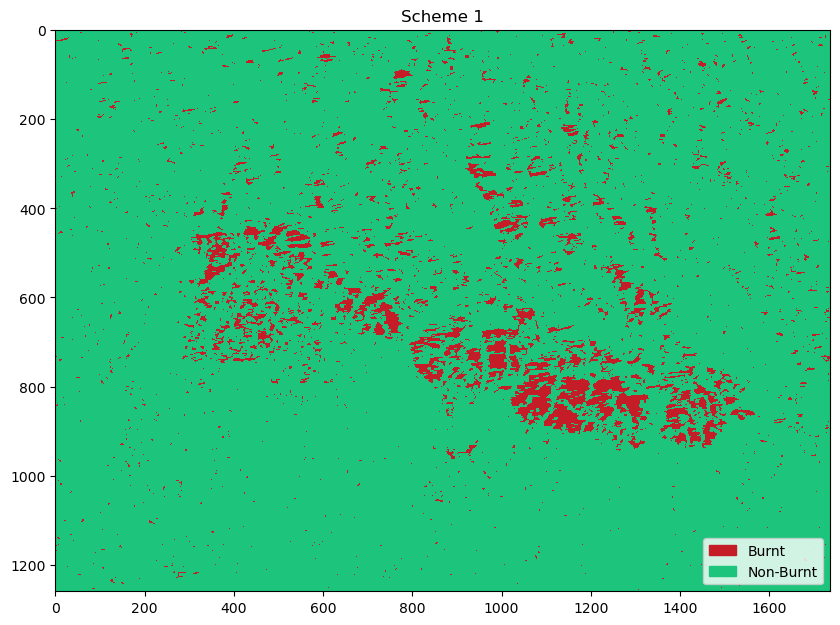

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/1_palisadesRF_sar_asc.tif


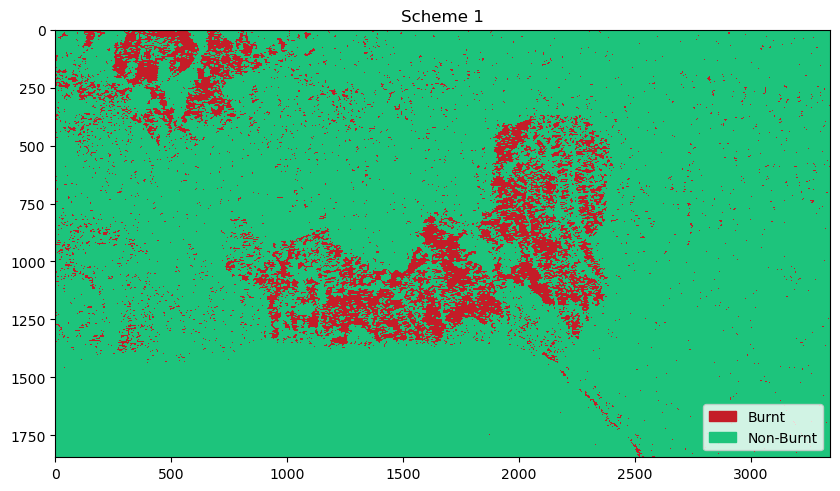

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/2_palisadesRF_eaton_sar_asc_glcm.tif


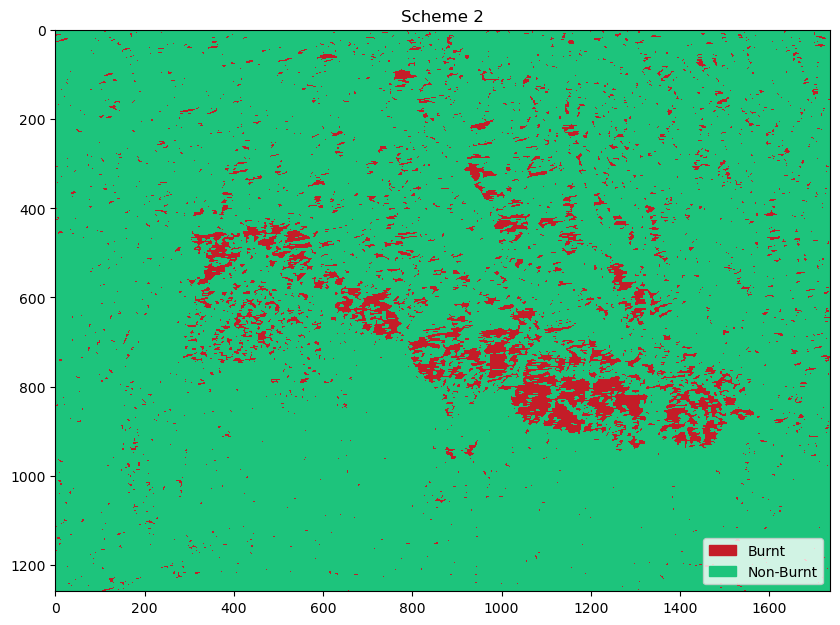

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/2_palisadesRF_sar_asc_glcm.tif


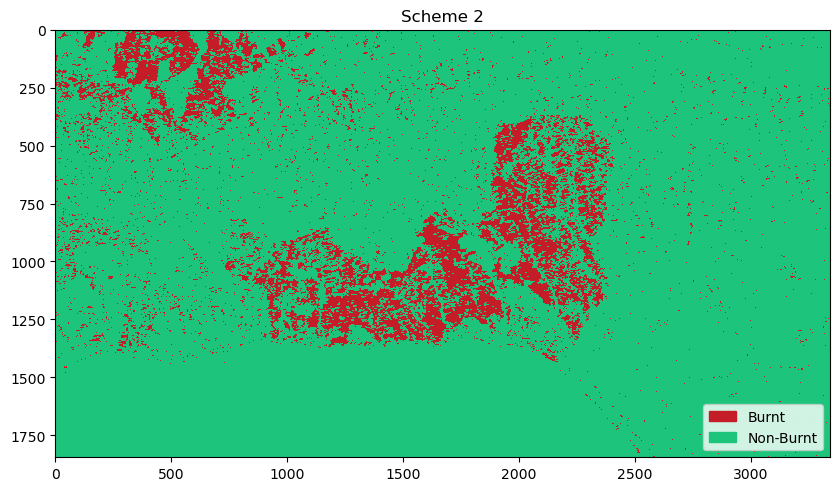

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/3_palisadesRF_eaton_sar_avgasc.tif


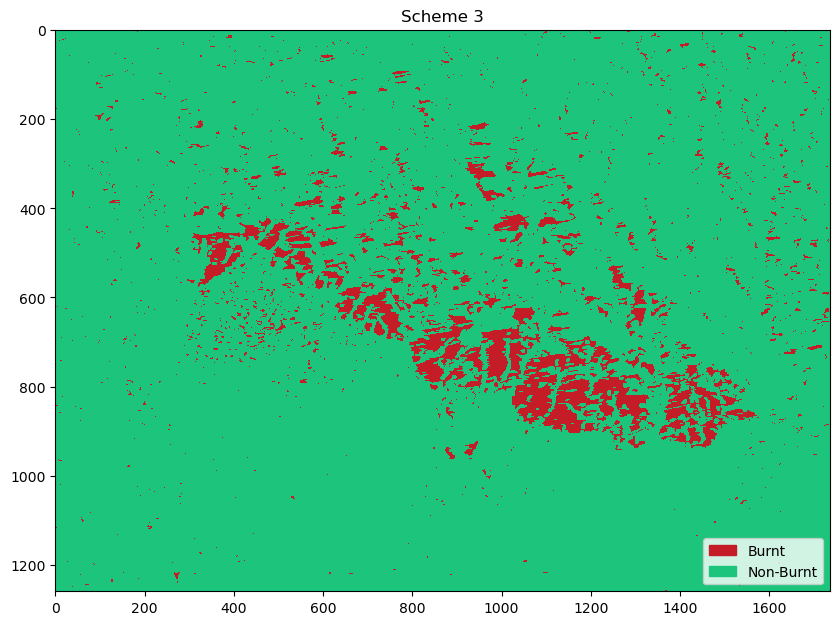

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/3_palisadesRF_sar_avgasc.tif


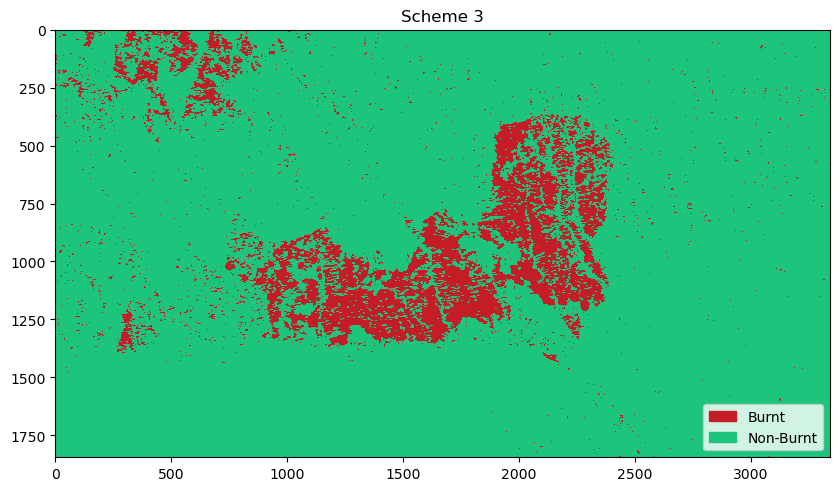

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/4_palisadesRF_eaton_sar_avgasc_glcm.tif


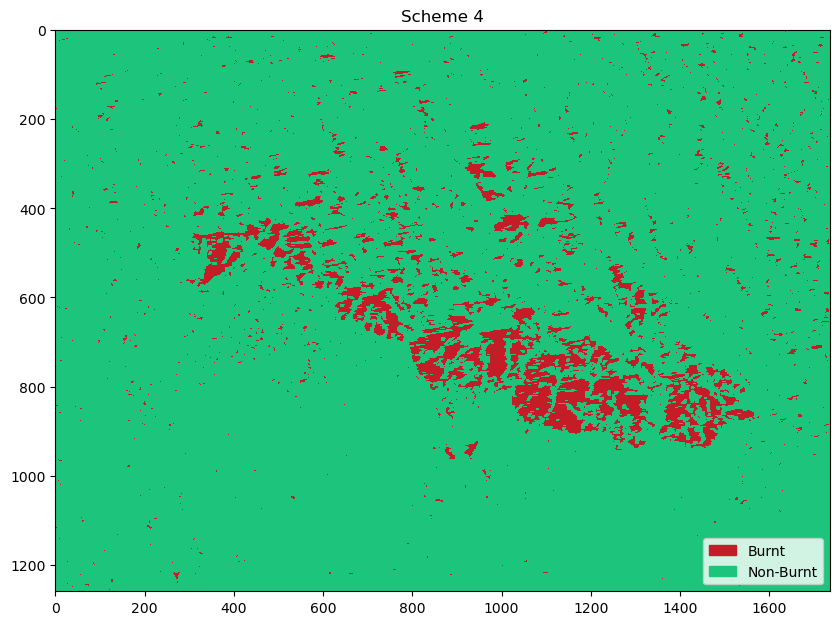

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/4_palisadesRF_sar_avgasc_glcm.tif


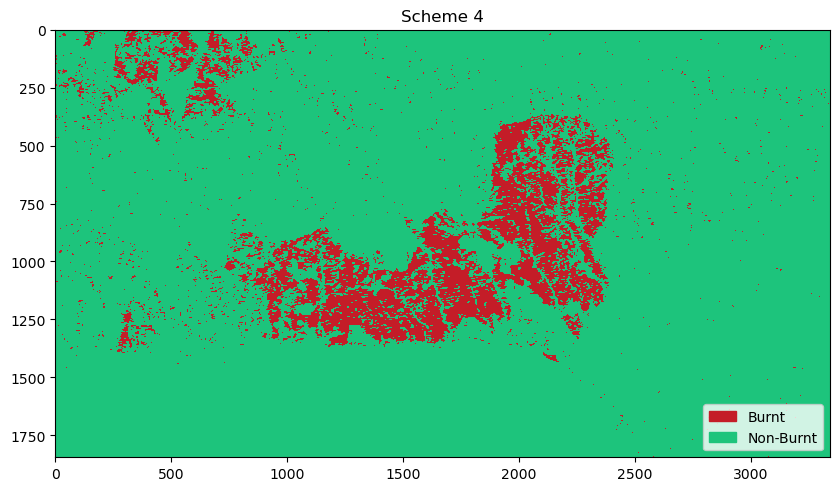

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/5_palisadesRF_eaton_sar_avgasc_desc.tif


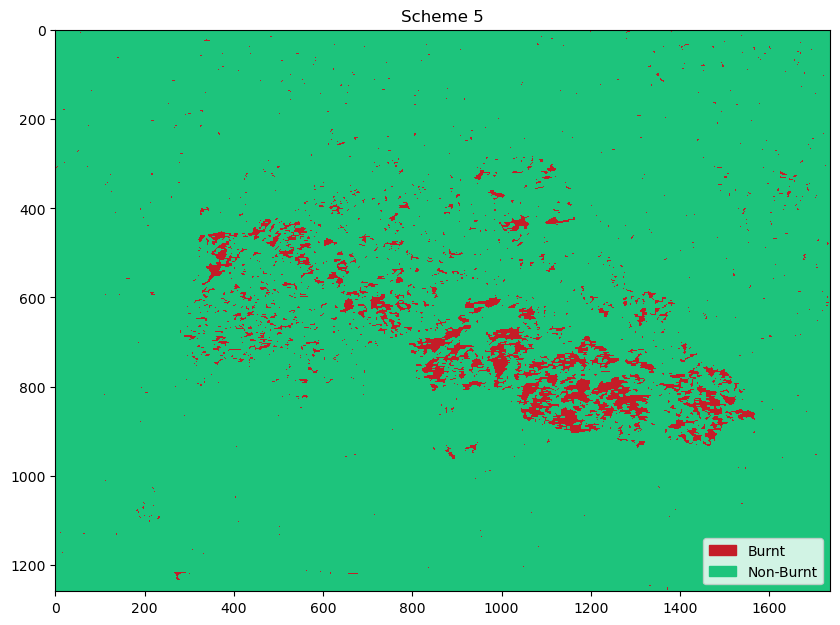

5


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/5_palisadesRF_sar_avgasc_desc.tif


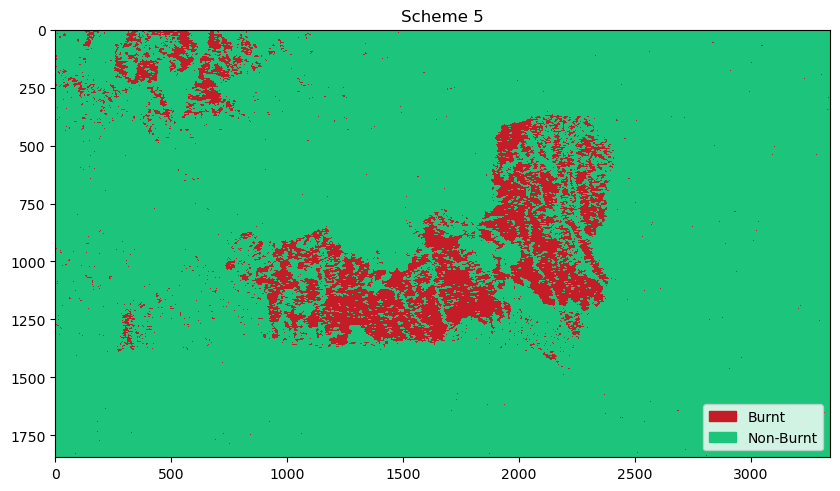

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/6_palisadesRF_eaton_sar_avgasc_desc_glcm.tif


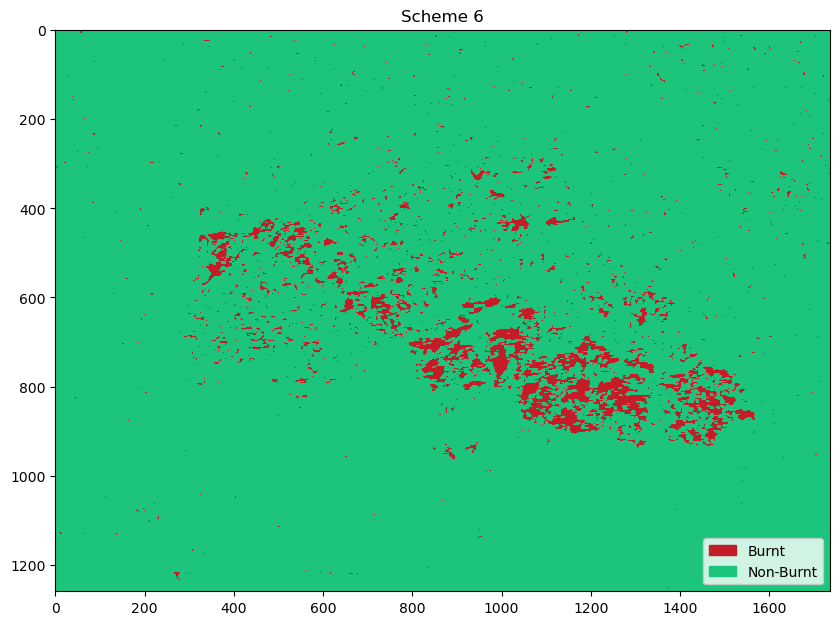

9


/Users/rabinatwayana/Rabina/anaconda3/envs/fire_env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0 1]
Predictions saved to output/prediction/6_palisadesRF_sar_avgasc_desc_glcm.tif


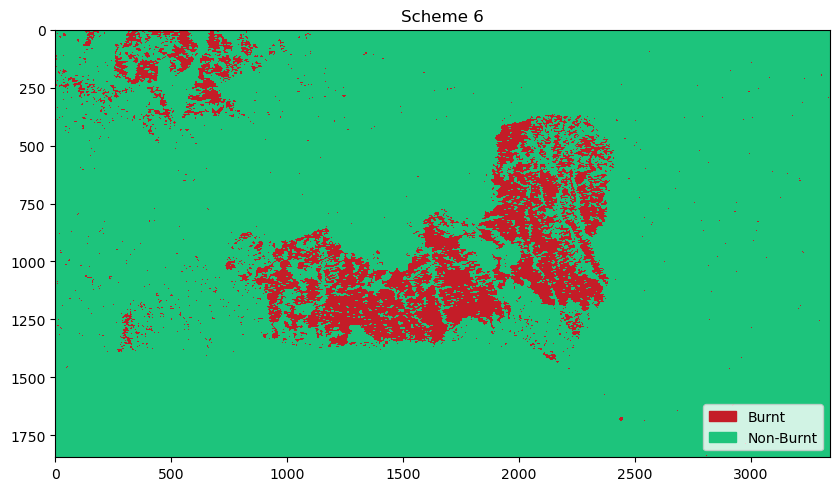

In [7]:
# Loop through each set of paths
for paths in file_paths:
    model_path = paths["model_path"]
    feature_image_path = paths["feature_image_path"]
    output_file_path = paths["output_file_path"]
    output_image_path=paths['output_image_path']
    title=paths['title']

    loaded_model = joblib.load(model_path)

    # Use the loaded model to make predictions
    # predictions = loaded_model.predict(X_test)
    predict(loaded_model, feature_image_path,output_file_path,output_image_path,title)

    # print(f"Processing Model: {model_path}")
    # print(f"Feature Image: {feature_image_path}")
    # print(f"Output File: {output_file_path}\n")